# **Medical Image Classification Using Convolutional Neural Networks (CNNs)**

###**1. Import Libraries**

In [ ]:
# --- Core Utilities and Data Handling ---
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image # For image loading/manipulation
from google.colab import drive # For Colab-specific mounts
import cv2 # Computer Vision utility

# --- Visualization and Reporting ---
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix

# --- Preprocessing and Sklearn Utilities ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample # For data balancing
from tensorflow.keras.utils import to_categorical # TensorFlow/Keras utility for one-hot encoding

# --- Deep Learning (TensorFlow/Keras) ---
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D # Keras Layers for building CNNs
from tensorflow.keras.applications import ResNet50 # Pre-trained deep learning model (for transfer learning)
from tensorflow.keras.applications.resnet50 import preprocess_input # Specific preprocessing function
from tensorflow.keras.optimizers import Adam # Keras Optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Keras Callbacks

###**2. Load Dataset and Initial Exploration**

In [ ]:
# Mount Google Drive for file access in Colab
drive.mount('/content/drive')

# Define the local path to the HAM10000 dataset folder
HAM_folder='/content/drive/MyDrive/Colab Notebooks/HAM10000_dataset'

# Change the current working directory to the dataset folder
os.chdir(HAM_folder)

# Verify the current working directory
!pwd

# Load the main metadata CSV into a pandas DataFrame
df = pd.read_csv(os.path.join(HAM_folder, 'pigmented_lesions_dataset/HAM10000_metadata.csv'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/HAM10000_dataset


In [ ]:
# --- Data Structure Check ---
print(f"DataFrame Shape (Rows, Columns): {df.shape}")

# Print the total number of records loaded (Rows)
print(f"Total Images: {df.shape[0]}")

DataFrame Shape (Rows, Columns): (10015, 7)
Total Images: 10015


In [ ]:
# --- Inspecting Data Content ---
# Display the first 10 rows of the DataFrame to inspect its structure and content
print("--- Displaying First 10 Rows ---")
df.head(10)

--- Displaying First 10 Rows ---


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
# Display the last 10 rows of the DataFrame
print("--- Displaying Last 10 Rows ---")
df.tail(10)

--- Displaying Last 10 Rows ---


,lesion_id,image_id,dx,dx_type,age,sex,localization
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face
10006,HAM_0004034,ISIC_0024948,akiec,histo,55.0,female,face
10007,HAM_0001565,ISIC_0028619,akiec,histo,60.0,female,face
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face
10009,HAM_0005705,ISIC_0031430,akiec,histo,75.0,female,lower extremity
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


__________________________________________________
         DIAGNOSTIC CATEGORY DISTRIBUTION         
__________________________________________________
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
__________________________________________________



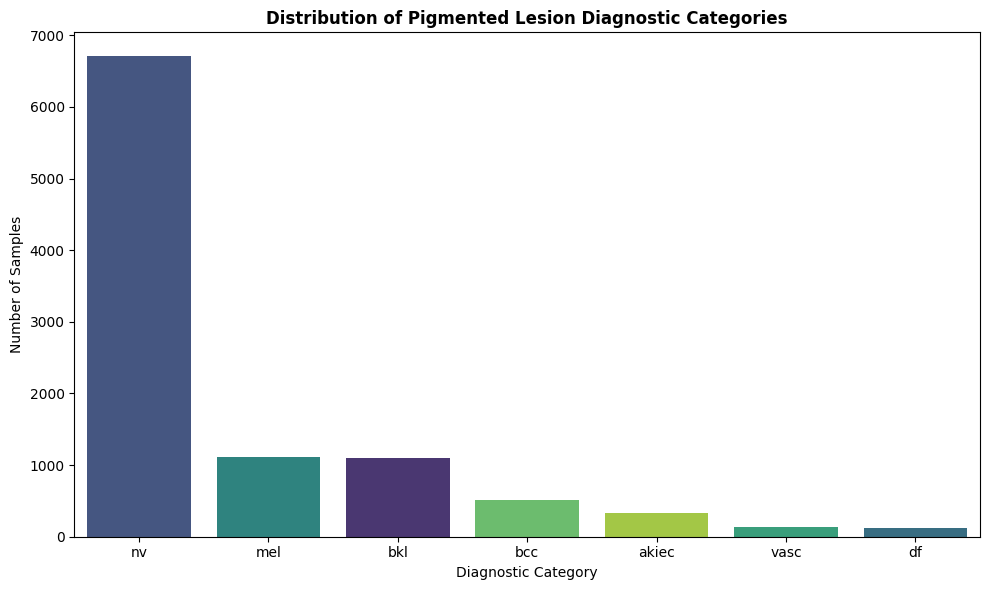

In [ ]:
# --- Class Distribution Analysis (Identifying Imbalance) ---
print(f"{'_'*50}")
print(f"{'DIAGNOSTIC CATEGORY DISTRIBUTION':^50}")
print(f"{'_'*50}")
# Calculate and print the count of each unique diagnostic category ('dx')
print(df['dx'].value_counts())
print(f"{'_'*50}\n")

# Determine the order for the bar plot (descending count)
sort = df['dx'].value_counts().index

# Create a figure for the visualization
plt.figure(figsize=(10, 6))

# 'order=sort' ensures the bars are sorted from largest to smallest
sns.countplot(x='dx', data=df, order=sort, palette='viridis', hue='dx', legend=False)

plt.xlabel('Diagnostic Category', fontsize=10)
plt.ylabel('Number of Samples', fontsize=10)
plt.title('Distribution of Pigmented Lesion Diagnostic Categories', fontsize=12, fontweight='bold')

# Adjust plot layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

###**3. Data Preprocessing**

In [ ]:
# --- Label Encoding (Categorical Strings to Integers) ---
print("--- Applying Label Encoding ---")

# Initialize the LabelEncoder
le = LabelEncoder()

# The resulting integer labels are stored in a new DataFrame column named 'label'
df['label'] = le.fit_transform(df['dx'])

print("Class Mapping (Integer Index to Diagnosis):")
for i, category in enumerate(le.classes_):
    print(f"  {i}: {category}")

print(f"{'_'*50}")
print("--- DataFrame Head showing new 'label' column ---")
display(df.head())

--- Applying Label Encoding ---
Class Mapping (Integer Index to Diagnosis):
  0: akiec
  1: bcc
  2: bkl
  3: df
  4: mel
  5: nv
  6: vasc
__________________________________________________
--- DataFrame Head showing new 'label' column ---


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


In [ ]:
# --- Class Balancing (Upsample / Downsample) ---
print(f"{'_'*50}")
print(f"{'BALANCED DIAGNOSTIC CATEGORY DISTRIBUTION':^50}")
print(f"{'_'*50}")

n_samples = 500  # desired samples per class
# Resample each class to have 500 samples
lesion_df = (
    df.groupby('label', group_keys=False)
      .apply(lambda x: resample(x, replace=True, n_samples=n_samples, random_state=42), include_groups=False)
      .reset_index(drop=True)
)

# Verify balance
print(lesion_df['dx'].value_counts())
print(f"{'_'*50}")
print(f"Total images after balancing: {len(lesion_df)}")

__________________________________________________
    BALANCED DIAGNOSTIC CATEGORY DISTRIBUTION     
__________________________________________________
dx
akiec    500
bcc      500
bkl      500
df       500
mel      500
nv       500
vasc     500
Name: count, dtype: int64
__________________________________________________
Total images after balancing: 3500


In [ ]:
# --- One-Hot Encoding (Integers to Binary Vectors) ---
# Convert the integer labels into a one-hot encoded format
# This creates the final target variable 'y' required for Keras/TensorFlow training
print("--- Applying One-Hot Encoding ---")

# Recreate the label column after balancing
lesion_df['label'] = le.transform(lesion_df['dx'])

y = to_categorical(lesion_df['label'], num_classes=len(le.classes_))

# Store the total number of classes
num_classes = len(le.classes_)

# Verify encoding
print("--- First 5 rows of One-Hot Encoded target 'y' ---")
print(y[:5])
print(f"{'_'*50}")

print(f"Balanced target variable 'y' created with shape: {y.shape}")
print(f"Total number of categories: {num_classes}")

--- Applying One-Hot Encoding ---
--- First 5 rows of One-Hot Encoded target 'y' ---
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
__________________________________________________
Balanced target variable 'y' created with shape: (3500, 7)
Total number of categories: 7


In [ ]:
# --- Resolve Image Paths ---
print("--- Resolving Image Paths ---")

image_dirs = [
    './pigmented_lesions_dataset/HAM10000_images_part_1',
    './pigmented_lesions_dataset/HAM10000_images_part_2',
    './pigmented_lesions_dataset/ham10000_images_part_1',
    './pigmented_lesions_dataset/ham10000_images_part_2'
    ]

# Function to find the correct image path
def resolve_path(image_id):
  for dir_path in image_dirs:
    image_path = os.path.join(HAM_folder, dir_path, f'{image_id}.jpg')
    if os.path.exists(image_path):
      return image_path
  return None # If not found in any folder

# Apply the function to create a new column
lesion_df['image_path'] = lesion_df['image_id'].apply(resolve_path)

# Display a small preview
print(f"Found image paths for {lesion_df['image_path'].notnull().sum()} samples out of {len(lesion_df)}")
print(f"{'_'*50}")
print("--- DataFrame Head showing 'image_path' column ---")
display(lesion_df.head())
print(f"{'_'*50}")
# --- Verify Image Path and Inspect One Sample ---
print("--- Verifying a sample image ---")

# Select the first valid image path (in case some are missing)
first_image_path = lesion_df['image_path'].dropna().iloc[0]

if os.path.exists(first_image_path):
    try:
        with Image.open(first_image_path) as img:
            print("Image opened successfully!")
            print(f"Image Size: {img.size}")
            print(f"Image Format: {img.format}")
    except Exception as e:
        print(f"Error opening image: {e}")
else:
    print(f"Image path does not exist: {first_image_path}")

--- Resolving Image Paths ---
Found image paths for 3500 samples out of 3500
__________________________________________________
--- DataFrame Head showing 'image_path' column ---


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,image_path
0,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,/content/drive/MyDrive/Colab Notebooks/HAM1000...
1,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,/content/drive/MyDrive/Colab Notebooks/HAM1000...
2,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,/content/drive/MyDrive/Colab Notebooks/HAM1000...
3,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,/content/drive/MyDrive/Colab Notebooks/HAM1000...
4,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,/content/drive/MyDrive/Colab Notebooks/HAM1000...


__________________________________________________
--- Verifying a sample image ---
Image opened successfully!
Image Size: (600, 450)
Image Format: JPEG


In [ ]:
# Display general info
print("DataFrame Information:")
lesion_df.info()
print("__________________________________")

# Display number of rows and columns
print("Shape (Rows, Columns):", lesion_df.shape)
print("__________________________________")

# Check for missing values
print("Missing values per column:")
print(lesion_df.isnull().sum())
print("__________________________________")

# Display number of unique categories
print("Number of unique diagnostic categories:", lesion_df['dx'].nunique())
print("Categories:", lesion_df['dx'].unique())

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     3500 non-null   object 
 1   image_id      3500 non-null   object 
 2   dx            3500 non-null   object 
 3   dx_type       3500 non-null   object 
 4   age           3488 non-null   float64
 5   sex           3500 non-null   object 
 6   localization  3500 non-null   object 
 7   label         3500 non-null   int64  
 8   image_path    3500 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 246.2+ KB
__________________________________
Shape (Rows, Columns): (3500, 9)
__________________________________
Missing values per column:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             12
sex              0
localization     0
label            0
image_path       0
dtype: int64
____________________

--- Displaying one sample from each diagnostic category ---


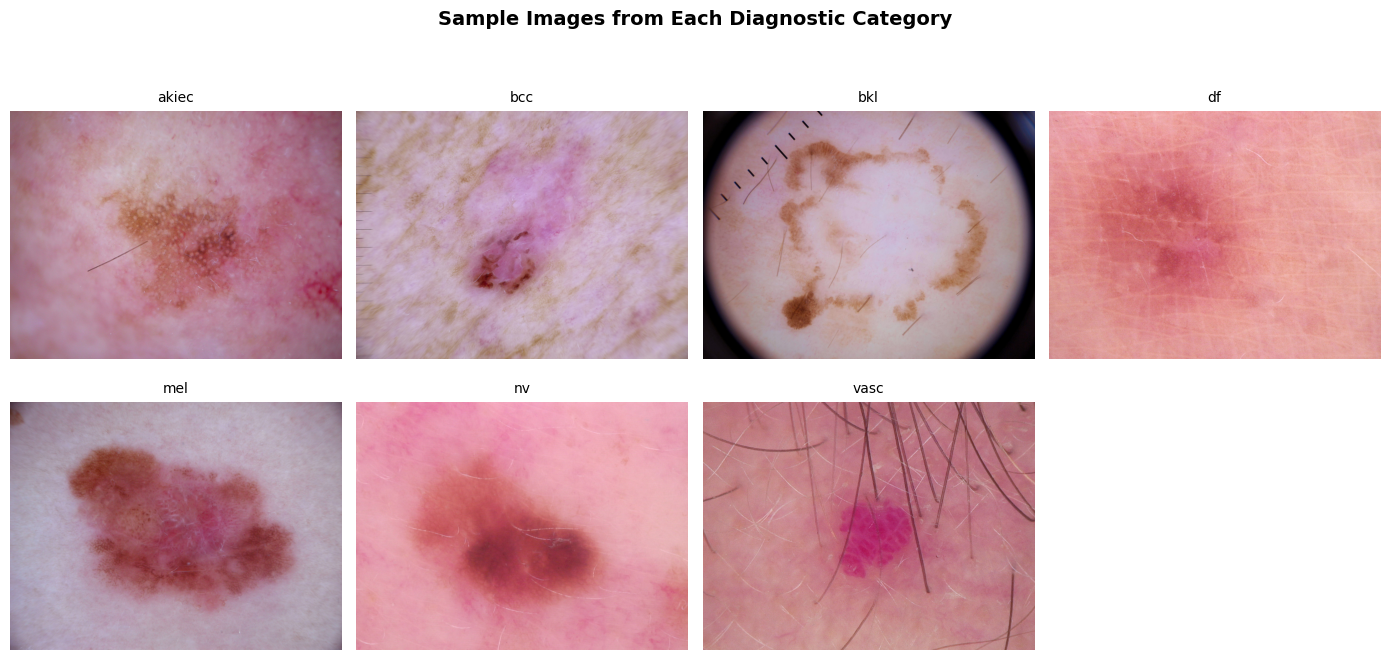

In [ ]:
print("--- Displaying one sample from each diagnostic category ---")

# Get unique categories and count
categories = lesion_df['dx'].unique()
num_categories = len(categories)

# Create figure
cols = 4
rows = (num_categories + cols - 1) // cols

plt.figure(figsize=(14, 7))

for i, category in enumerate(categories):
    try:
        # Randomly select one image from this category
        sample = lesion_df[lesion_df['dx'] == category].sample(1, random_state=42).iloc[0]
        image_path = sample['image_path']
        img = mpimg.imread(image_path)

        # Plot the image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{category}", fontsize=10)
        plt.axis('off')

    except Exception as e:
        print(f"Could not load image for {category}: {e}")

plt.suptitle("Sample Images from Each Diagnostic Category", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# --- Load and Resize Images ---
print("--- Loading and resizing images ---")

img_size = 224
X, y = [], []

for _, row in tqdm(lesion_df.iterrows(), total=len(lesion_df)):
    image_path = row['image_path']
    category = row['label']

    # Skip invalid or missing paths
    if not isinstance(image_path, str) or not os.path.exists(image_path):
        continue

    try:
        # Read and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))

        # Append to lists
        X.append(img)
        y.append(category)

    except Exception as e:
        print(f"Error reading image {image_path}: {e}")
        continue

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y)

print("__________________________________")
print("Dataset loaded and resized successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example image pixel range:", X.min(), "to", X.max())

--- Loading and resizing images ---


100%|██████████| 3500/3500 [01:04<00:00, 54.49it/s]


__________________________________
Dataset loaded and resized successfully!
X shape: (3500, 224, 224, 3)
y shape: (3500,)
Example image pixel range: 0.0 to 255.0


###**4. Split Dataset**

In [ ]:
# --- Lesion-based Split (Prevent Image Leakage) ---
unique_lesions = lesion_df['lesion_id'].unique()

# Split 70% train, 30% temp (val+test)
train_lesions, temp_lesions = train_test_split(
    unique_lesions, test_size=0.3, random_state=42, shuffle=True
)

# Split temp (30%) into val (15%) and test (15%)
val_lesions, test_lesions = train_test_split(
    temp_lesions, test_size=0.5, random_state=42
)

# Map lesion IDs to each subset
train_df = lesion_df[lesion_df['lesion_id'].isin(train_lesions)]
val_df = lesion_df[lesion_df['lesion_id'].isin(val_lesions)]
test_df = lesion_df[lesion_df['lesion_id'].isin(test_lesions)]

# Verify no leakage
assert not set(train_df['lesion_id']).intersection(val_df['lesion_id'])
assert not set(train_df['lesion_id']).intersection(test_df['lesion_id'])
assert not set(val_df['lesion_id']).intersection(test_df['lesion_id'])

print(f"Data split completed successfully!")
print(f"Train set: {len(train_df)} | Validation set: {len(val_df)} | Test set: {len(test_df)}")
print("No overlap between lesion IDs detected")

Data split completed successfully!
Train set: 2478 | Validation set: 516 | Test set: 506
No overlap between lesion IDs detected


In [ ]:
# --- Link NumPy images to DataFrame splits ---
print("--- Linking image data to train/val/test splits ---")

# Create dictionaries for quick lookup
image_to_index = {img_id: idx for idx, img_id in enumerate(lesion_df['image_id'])}

def get_split_data(df):
    indices = [image_to_index[iid] for iid in df['image_id'] if iid in image_to_index]
    # Ensure the target variable is one-hot encoded and has the correct shape
    return X[indices], y[indices]

X_train, y_train = get_split_data(train_df)
X_val, y_val = get_split_data(val_df)
X_test, y_test = get_split_data(test_df)

# One-hot encode the target variables after splitting
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"Split arrays created successfully!")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

--- Linking image data to train/val/test splits ---
Split arrays created successfully!
X_train: (2478, 224, 224, 3), X_val: (516, 224, 224, 3), X_test: (506, 224, 224, 3)
y_train: (2478, 7), y_val: (516, 7), y_test: (506, 7)


###**5. Image Preparation and Augmentation**

In [ ]:
# --- Data Augmentation Setup ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# --- Data Generators for Batching ---
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)
print("Data augmentation and batch generators initialized successfully!")

Data augmentation and batch generators initialized successfully!


###**6. Build the Model (ResNet50)**

In [ ]:
# --- Model Setup ---
# Define input shape and number of classes
input_shape = (img_size, img_size, 3)

# Load the base model (ResNet50 pre-trained on ImageNet)
# include_top=False: Excludes the final classification layers of ResNet, allowing us to attach our own custom classification head
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# --- Base Model Layer Freezing ---
# Freeze the weights of the pre-trained ResNet50 base
# This ensures that only the newly added layers (the 'head') are trained initially
for layer in base_model.layers:
    layer.trainable = False

# --- Custom Classification Head (Top Layers) ---
# Start building the new layers on top of the frozen base model's output
x = base_model.output

# Global Average Pooling reduces the spatial dimensions
x = GlobalAveragePooling2D()(x)

# First Dense (Fully Connected) layer for deep feature representation
x = Dense(512, activation='relu')(x)

# Dropout randomly sets 50% of input units to 0, which helps prevent overfitting
x = Dropout(0.5)(x)

# Final output layer: one neuron for each of the 'num_classes' categories,
# using 'softmax' to output a probability distribution summing to 1
outputs = Dense(num_classes, activation='softmax')(x)

# --- Final Model Construction ---
# Combine the input of the base model with the output of the custom head
model = Model(inputs=base_model.input, outputs=outputs)

In [ ]:
# Display the model architecture (layers, output shapes, and number of trainable parameters)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

###**7. Compile and Train**

In [ ]:
# --- Model Compilation ---
# Define the optimizer (Adam is efficient) and the learning rate (0.0001 is stable for transfer learning)
optimizer = Adam(learning_rate=0.0001)

# Use 'categorical_crossentropy' since the labels are one-hot encoded (y)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# --- Training Configuration ---
epochs = 20
# Define the number of samples processed before the model's parameters are updated
batch_size = 32

# --- Training the Model ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Train only the top layers (base model is frozen)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 515s 7s/step - accuracy: 0.2546 - loss: 2.2517 - val_accuracy: 0.5543 - val_loss: 1.2793 - learning_rate: 1.0000e-04
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 503s 6s/step - accuracy: 0.4626 - loss: 1.4334 - val_accuracy: 0.6047 - val_loss: 1.0946 - learning_rate: 1.0000e-04
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 573s 7s/step - accuracy: 0.5587 - loss: 1.1913 - val_accuracy: 0.6163 - val_loss: 1.0367 - learning_rate: 1.0000e-04
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.6139 - loss: 1.0574 - val_accuracy: 0.6492 - val_loss: 0.9828 - learning_rate: 1.0000e-04
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 504s 6s/step - accuracy: 0.6276 - loss: 0.9829 - val_accuracy: 0.6357 - val_loss: 0.9408 - learning_rate: 1.0000e-04
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 505s 6s/step - accuracy: 0.6547 - loss: 0.9416 - val_accuracy: 0.6202 - val_loss: 0.9572 - learning_rate: 1.0000e-04
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.6777 

###**8. Evaluate and Visualize Results**

In [ ]:
# --- Final Model Evaluation ---
''' Evaluate the model's performance on the reserved, unseen test set,
This provides the best estimate of how the model will perform in a real-world scenario '''
# model.evaluate runs the model against the test data and returns the loss and metrics (accuracy)
test_loss, test_acc = model.evaluate(test_generator)

# Print the final test accuracy, formatted to 4 decimal places for precision
print(f"Test Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.5753 - loss: 1.1157
Test Accuracy: 0.6502


In [ ]:
# --- Example Prediction on a Single Image ---
sample_image = X_test[5]
image_for_model = np.expand_dims(sample_image, axis=0)

pred = model.predict(image_for_model)
predicted_class = np.argmax(pred)
print(f"Predicted: {le.classes_[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: akiec


In [ ]:
# --- Model Predictions and Output Interpretation ---
# Predict probabilities for each class on the test set
predictions = model.predict(test_generator)

# Each row in 'predictions' contains 7 probability values (one per class)
print("Predictions shape:", predictions.shape)

# Example: take the first test image’s prediction
first_pred = predictions[0]
print("Class probabilities:", first_pred)

# Apply argmax to find the class with the highest probability
predicted_class = np.argmax(first_pred)
print("Predicted class index:", predicted_class)

# Get class labels from the LabelEncoder
class_labels = list(le.classes_)
print("Predicted class label:", class_labels[predicted_class])

16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step
Predictions shape: (506, 7)
Class probabilities: [5.5675739e-01 2.2352661e-01 1.0286812e-01 6.5700440e-03 1.0858365e-01
 1.2925413e-03 4.0165897e-04]
Predicted class index: 0
Predicted class label: akiec


--- Training History Plots ---


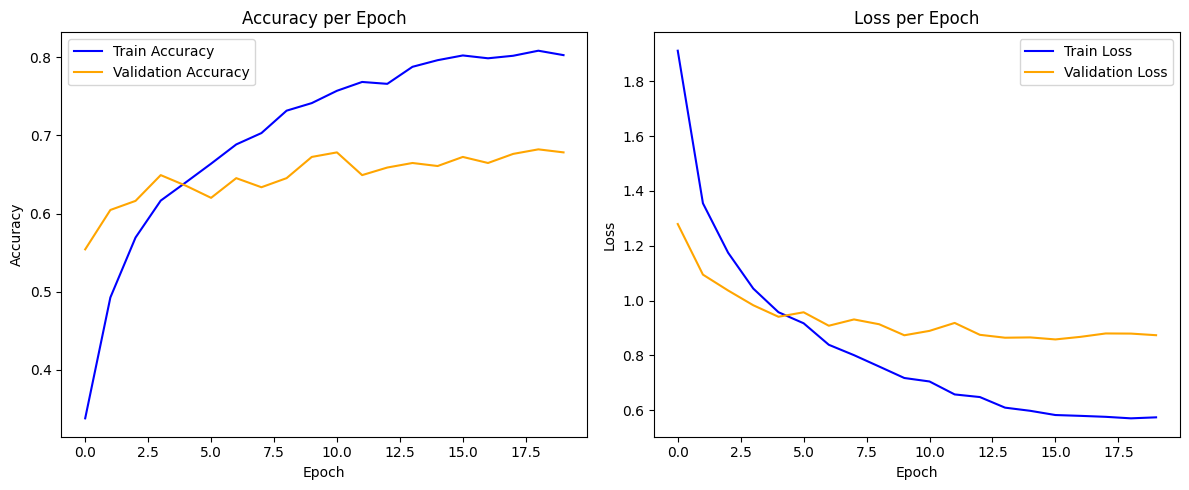

In [ ]:
# Training History Plots (Accuracy and Loss)
print("--- Training History Plots ---")
# Accuracy per Epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.legend()

# Loss per Epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Classification Report ---
print("_"*50)
print("--- Comprehensive Classification Report ---")
print("_"*50)

# Get true and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(predictions, axis=1)

# Print classification metrics
# Displays Precision, Recall, F1-Score, and Support for each diagnostic category
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

__________________________________________________
--- Comprehensive Classification Report ---
__________________________________________________
              precision    recall  f1-score   support

       akiec       0.43      0.48      0.46        58
         bcc       0.61      0.61      0.61        87
         bkl       0.56      0.73      0.63        73
          df       0.56      0.41      0.47        49
         mel       0.53      0.53      0.53        80
          nv       0.86      0.71      0.78        80
        vasc       0.99      0.96      0.97        79

    accuracy                           0.65       506
   macro avg       0.65      0.63      0.64       506
weighted avg       0.66      0.65      0.65       506



--- Confusion Matrix ---


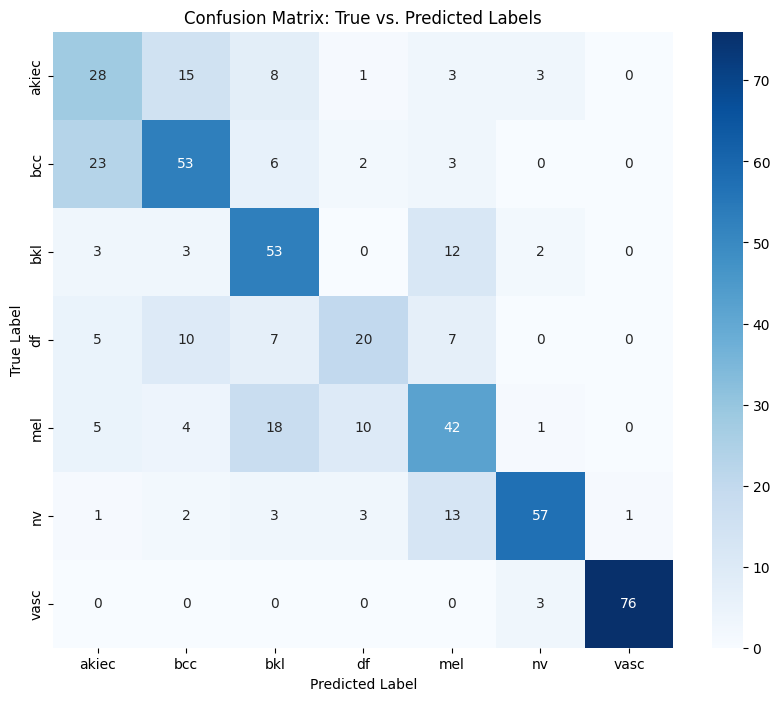

In [ ]:
# --- Confusion Matrix Visualization ---
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_classes)

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: True vs. Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()